In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# Node Classification with Graph Neural Networks

* Cora
     * 1433-dimensional bag-of-words feature vector 
* label
     * 7 class 
     
## [cora](https://graphsandnetworks.com/the-cora-dataset/)

In [17]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [18]:
import numpy as np
np.bincount(data.train_mask) , np.bincount(data.y)

(array([2568,  140]), array([351, 217, 418, 818, 426, 298, 180]))

In [21]:
dataset

Cora()

In [29]:
import seaborn as sns
#sns.heatmap(data.x.detach().numpy())
data.x.detach().numpy().sum()

2708.0012

In [11]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

# Multi Layer Perceptron

* its bag-of-words feature representation, without taking any relational information into account.

In [30]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [32]:
from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from IPython.display import HTML , clear_output
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
import sys

class Printer():
    """Print things to stdout on one line dynamically"""
    def __init__(self,num_period=10):
        self.num_period = num_period
        self.init_value = 0

    def __call__(self,data) :
        if self.init_value % self.num_period == 0 :
            print('\n'+data.__str__())
            self.init_value = 1
        else :
            sys.stdout.write("\r\x1b[K"+data.__str__())
            sys.stdout.flush()
            self.init_value += 1 

printf = Printer(num_period=50)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 100):
    loss = train()
    printf(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9615
Epoch: 050, Loss: 1.0563
Epoch: 051, Loss: 0.9893
Epoch: 099, Loss: 0.5008

In [33]:
def progressBar(iterable, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    total = len(iterable)
    # Progress Bar Printing Function
    def printProgressBar (iteration):
        percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Initial Call
    printProgressBar(0)
    # Update Progress Bar
    for i, item in enumerate(iterable):
        yield item
        printProgressBar(i + 1)
    # Print New Line on Complete
    print()


import time
# A List of Items
items = list(range(0, 57))
l = len(items)

for item in progressBar(items, prefix = 'Progress:', suffix = 'Complete', length = 50,fill="#"):
    # Do stuff...
    time.sleep(0.1)

Progress: |##################################################| 100.0% Complete


In [34]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5660


# GNN

* MLP는 성능이 낮음
    * small amount of training nodes로 인해 과적합함. 

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$


where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

# [좋은 자료](https://neptune.ai/blog/graph-neural-network-and-some-of-gnn-applications)


In [ ]:
import torch
from torch import nn

class GCN(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(x, y) for x, y in zip(sizes[:-1], sizes[1:])
        ])
    def forward(self, vertices, edges):
        # ----- Build the adjacency matrix -----
        # Start with self-connections
        adj = torch.eye(len(vertices))
        # edges contain connected vertices: [vertex_0, vertex_1] 
        adj[edges[:, 0], edges[:, 1]] = 1 
        adj[edges[:, 1], edges[:, 0]] = 1
        
        # ----- Forward data pass -----
        for layer in self.layers:
            vertices = torch.sigmoid(layer(adj @ vertices))
 
        return vertices

In [35]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# 2D EMBEDDING

저차원으로 차원 축소하여 시각화

In [37]:
import umap
def visualize(h, color):
    z = umap.UMAP(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

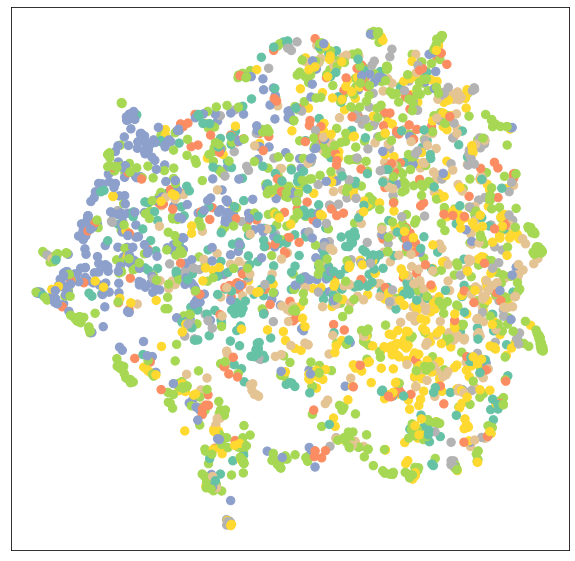

In [55]:
model = GCN(hidden_channels=32)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [56]:
train_idx = np.random.choice(np.where(data.train_mask)[0] , 100 )
np.random.shuffle(train_idx)
train_idx, valid_idx = train_idx[:80], train_idx[80:]
train_idx

array([ 47, 105, 129,  39,  31,  47, 133,  41,  34,   1,  49,  13, 113,
        93, 121,  14,  54,  24,  21,  98,   6,  40, 104,  41,  14, 108,
        11,  64,  38,   2, 118,  69,  38,  95, 114,  57,  45,  59,  52,
        67,  78,  50,  94,  87,  76,   8,  41,  23, 138,  58,  43,  95,
         0, 117,  80,  57,  14, 115,  98,  15,  36,  30, 128,  89,  95,
        32,  25,   2,   2,   7, 139,  45,  45, 136,  18,  10, 100,  12,
        42,  74])

In [62]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_idx], data.y[train_idx])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def valid() :
      model.eval()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[valid_idx], data.y[valid_idx])  # Compute the loss solely based on the training nodes.      
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


printf = Printer(num_period=50)
loss_log = 2
for epoch in range(1, 501):
    loss = train()
    valid_loss = valid()
    printf(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Valid Loss : {valid_loss:.4f}')
    if loss_log > valid_loss :
          loss_log = valid_loss
          best_weight = model.state_dict()
model.load_state_dict(best_weight)
test_acc = test()
print("")
print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 001, Loss: 1.9451, Valid Loss : 1.9438
Epoch: 050, Loss: 0.9977, Valid Loss : 1.4990
Epoch: 051, Loss: 0.9951, Valid Loss : 1.4840
Epoch: 100, Loss: 0.4466, Valid Loss : 0.9911
Epoch: 101, Loss: 0.4579, Valid Loss : 0.9867
Epoch: 129, Loss: 0.3952, Valid Loss : 0.8618

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


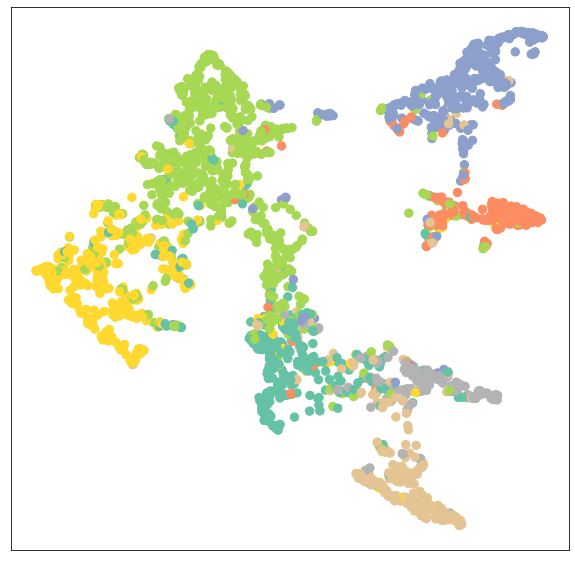

In [43]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# 결론

* MLP보다 GNN을 쓰면 성능 개선에 효과적임. 

